In [1]:
import mat73

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

### Load data

In [2]:
# Which session is loaded in 
ses_nr = 3

In [3]:
session_labels = mat73.loadmat(f'dataset_conditions\session_{ses_nr}_condition.mat')
session_dict = mat73.loadmat(f'session_{ses_nr}.mat')

In [4]:
data = session_dict['data']
spiketrain = data['spiketrain']
neuron_used = data['Cluster_Included']

labels = session_labels['trial_condition_ID']


#shorten length spiketrain / slice specific part
#spiketrain = spiketrain[:, 100:, :]

print(spiketrain.shape, labels.shape)

(2160, 1100, 442) (2160,)


In [34]:
# use when selecting 'active' neurons only
active_dict = []
inactive_dict = []

for i in range(len(spiketrain[1][1])):
    if neuron_used[i] == True:
        active_dict.append(spiketrain[:, :, i])
    elif neuron_used[i] == False:
        inactive_dict.append(spiketrain[i])

active_dict = np.array(active_dict)
active_dict = np.transpose(active_dict, (1, 2, 0))

#active_dict = torch.tensor(active_dict, dtype = torch.int)
active_dict.shape

(2160, 1100, 115)

##### Decode labels

In [5]:
## Get orientation (0 -> 350)

orientation = [(int(i) % 36 - 1) if int(i) % 36 != 0 else 35 for i in labels]

#orientation = torch.tensor(orientation, dtype = torch.int)

In [6]:
### Get spatial frequency (0.5, 1, 2, 4)
sf = []

for i in labels:
    if i <= 144:
        if i/36 <= 1:
            sf.append(0.5)

        elif i/36 <= 2:
            sf.append(1)

        elif i/36 <= 3:
            sf.append(2)

        elif i/36 <= 4:
            sf.append(4)


    elif 145 <= i <= 288:
        if i/36 <= 5:
            sf.append(0.5)

        elif i/36 <= 6:
            sf.append(1)

        elif i/36 <= 7:
            sf.append(2)

        elif i/36 <= 8:
            sf.append(4)


    elif 289 <= i <= 432:
        if i/36 <= 9:
            sf.append(0.5)

        elif i/36 <= 10:
            
            sf.append(1)

        elif i/36 <= 11:
            sf.append(2)

        elif i/36 <= 12:
            sf.append(4)

#sf = torch.tensor(sf, dtype = torch.float64)

In [7]:
zipped = list(zip(spiketrain, orientation))
#zipped_sf = list(zip(spiketrain, sf))
#zipped_active = list(zip(active_dict, orientation))
spike_neuron = np.transpose(spiketrain)

### Sorting Functions

In [8]:
def Sort_Degrees(neuron_nr):
    # Initialize grad_dict with lists
    numbers = list(range(0, 360, 10)) 
    for nr in numbers:
        grad_dict[f'grad_{nr}'] = []  # Initialize an empty list for each counter value

    # Process the zipped list
    for i in zipped:
        counter = 0
        for nr in numbers:
            if i[1] == counter:
                grad_dict[f'grad_{counter*10}'].append(i[0][:, neuron_nr-1])
                break  # Exit the loop once the correct grad list is found
            counter += 1

    # Print the results
    #for nr in numbers:
    #    print(f'grad_{nr}:', grad_dict[f'grad_{nr}'])

In [9]:
def Sort_SF(neuron_nr):
    numbers = [0.5, 1, 2, 4] 
    for nr in numbers:
        sf_dict[f'sf_{nr}'] = []  # Initialize an empty list for each counter value

    # Process the zipped list
    for i in zipped_sf:
        counter = 0
        for nr in numbers:
            if i[1] == numbers[counter]:
                sf_dict[f'sf_{nr}'].append(i[0][:, neuron_nr-1])
                break  # Exit the loop once the correct grad list is found
            counter += 1

In [10]:
# Get spike count of trial -> average spike count over all trials 
# divide spike avg by nr trials * time window duration

# to convert to Hz, multiply by 1000

def Tuning_Curve(neuron):
    avg_rates = []
    trial_avg_rates = []

    numbers = list(range(0, 360, 10))
    for nr in numbers:
        orientation = grad_dict[f'grad_{nr}']
        rates = []
        for session in orientation:
            rates.append(sum(session))
        avg_rates.append(sum(rates))

    for rate in avg_rates:
        avg = rate/(40*1000) # should change depending on nr of trials per orientation
        trial_avg_rates.append(avg)

    # plotting
    plt.figure().set_figwidth(15)
    plt.title(f"Tuning curve neuron {neuron}") 
    plt.xlabel('orientation (deg)') 
    plt.xticks(numbers)
    plt.ylabel("Avg firing rates") 
    plt.plot(numbers, trial_avg_rates, color ="red") 
    plt.savefig(f"Tuning Curve Neuron {neuron}.jpg")
    plt.close()

In [11]:
def Tuning_Curve_SF(neuron):
    avg_rates = []
    trial_avg_rates = []

    numbers = [0.5, 1, 2, 4] 
    for nr in numbers:
        frequency = sf_dict[f'sf_{nr}']
        rates = []
        for session in frequency:
            rates.append(sum(session))
        avg_rates.append(sum(rates))

    for rate in avg_rates:
        avg = rate/(40*1100) # should change depending on nr of trials per orientation
        trial_avg_rates.append(avg)

    # plotting
    #plt.figure().set_figwidth(15)
    plt.title(f"Tuning curve SF neuron {neuron}") 
    plt.xlabel('Spatial Frequency') 
    plt.xticks(numbers)
    plt.ylabel("Avg firing rates") 
    plt.plot(numbers, trial_avg_rates, color ="red") 
    plt.savefig(f"Tuning Curve SF Neuron {neuron}.jpg")
    plt.close()

In [12]:
def Sort_Activity(data):
    neuron_nr = 1
    active_dict['active'] = []
    active_dict['inactive'] = []

    for item in data:
        if item == True:
            active_dict['active'].append(neuron_nr)
        elif item == False:
            active_dict['inactive'].append(neuron_nr)
        neuron_nr += 1

In [11]:
def Tuning_Index(neuron):
    avg_rates = []
    trial_avg_rates = []
    
    numbers = list(range(0, 360, 10))
    for nr in numbers:
        orientation = grad_dict[f'grad_{nr}']
        rates = []
        for session in orientation:
            rates.append(sum(session))
        avg_rates.append(sum(rates))

    for rate in avg_rates:
        avg = rate/(60*1000)   # should change depending on nr of trials per orientation
        trial_avg_rates.append(avg)

    A = np.array(trial_avg_rates)
    maximum_indices = np.where(A==max(trial_avg_rates))

    if len(maximum_indices[0]) == 1:
        preferred_deg = int(maximum_indices[0])
        non_preferred_deg = (preferred_deg + 9) % 36
    else:
        multiples.append(neuron)
        preferred_deg = int(maximum_indices[0][0])
        non_preferred_deg = (preferred_deg + 9) % 36

    preferred = trial_avg_rates[preferred_deg]
    non_preferred = trial_avg_rates[non_preferred_deg]

    index = (preferred - non_preferred)/(preferred + non_preferred)
    tuning_index.append([neuron, index])

In [26]:
def Tuning_Index_SF(neuron):
    avg_rates = []
    trial_avg_rates = []
    

    numbers = [0.5, 1, 2, 4] 
    for nr in numbers:
        frequency = sf_dict[f'sf_{nr}']
        rates = []
        for session in frequency:
            rates.append(sum(session)) #contains sum of all spikes of one trial 
        avg_rates.append(sum(rates)) #contains the sum of 

    for rate in avg_rates:
        avg = rate/(60*1000)   # should change depending on nr of trials per orientation
        trial_avg_rates.append(avg)

    A = np.array(trial_avg_rates)
    maximum_indices = np.where(A==max(trial_avg_rates))
    minimum_indices = np.where(A==min(trial_avg_rates))

    if len(maximum_indices[0]) == 1:
        preferred_SF = int(maximum_indices[0])
        non_preferred_SF = int(minimum_indices[0][0])  #take the min() as non-prefferred?
    else:
        multiples.append(neuron)
        preferred_SF = int(maximum_indices[0][0])
        non_preferred_SF = int(minimum_indices[0][0])

    preferred = trial_avg_rates[preferred_SF]
    non_preferred = trial_avg_rates[non_preferred_SF]

    index = (preferred - non_preferred)/(preferred + non_preferred)
    tuning_index_SF.append([neuron, index])

### Apply the desired type of analysis (orientation/SF/selected neuron)

In [22]:
grad_dict = {}
multiples = []
tuning_index = []

for neuron in range(1, 400):
    Sort_Degrees(neuron)
    Tuning_Index(neuron)


print(multiples)

C:\Users\marin\AppData\Local\Temp\ipykernel_9888\2209280981.py:31: RuntimeWarning: invalid value encountered in double_scalars
  index = (preferred - non_preferred)/(preferred + non_preferred)


[11, 12, 25, 33, 36, 39, 62, 94, 98, 115, 125, 126, 135, 152, 157, 159, 163, 165, 166, 167, 186, 195, 206, 219, 223, 226, 227, 229, 247, 252, 254, 266, 270, 272, 284, 292, 295, 300, 302, 309, 311, 312, 317, 319, 324, 326, 342, 351, 354, 357, 358, 363, 364, 365, 370, 373, 374, 379, 381, 387, 388, 390, 391, 396]


In [24]:
print(len(tuning_index))
print(len(multiples))

### Assess the amount of neurons with a tuning index above a certain threshold
b = [index[1] for index in tuning_index]
# amount above 0.5 tune
nr = 0
for i in range(len(b)):
    if b[i]>0.8:
        nr +=1

print(nr/len(b)*100)

399
64
44.3609022556391


Session 2 - orientation
- above 0.3 tuning : 70.8830548926014
- above 0.5 tuning : 48.92601431980907
- above 0.8 tuning : 22.195704057279237


On selected neurons:
- above 0.3 tuning : 63.366336633663366
- above 0.5 tuning : 42.57425742574257
- above 0.8 tuning : 14.85148514851485

Session 3 - orientation
- above 0.3 tuning : 91.17647058823529
- above 0.5 tuning : 73.52941176470588
- above 0.8 tuning : 44.34389140271493

On selected neurons:
- above 0.3 tuning : 91.4027149321267
- above 0.5 tuning : 71.04072398190046
- above 0.8 tuning : 34.38914027149321

Session 5 - orientation
- above 0.3 tuning : 61.49341142020498
- above 0.5 tuning : 31.625183016105417
- above 0.8 tuning : 12.591508052708638

On selected neurons:
- above 0.3 tuning : 58.26086956521739
- above 0.5 tuning : 26.956521739130434
- above 0.8 tuning : 5.217391304347826

In [27]:
sf_dict = {}
multiples = []
tuning_index_SF = []

for neuron in range(1, 420):
    Sort_SF(neuron)
    Tuning_Index_SF(neuron)


print(multiples)

C:\Users\marin\AppData\Local\Temp\ipykernel_5744\1645822510.py:33: RuntimeWarning: invalid value encountered in double_scalars
  index = (preferred - non_preferred)/(preferred + non_preferred)


[7, 8, 12, 14, 23, 56, 108, 131, 157, 166, 185, 187, 224, 234, 241, 253, 289, 346, 388]


In [32]:
c = [index[1] for index in tuning_index_SF]
# amount above 0.5 tune
nr = 0
for i in range(len(c)):
    if c[i]>0.3:
        nr +=1

print(nr/len(c)*100)

81.86157517899761


Session 2 - SF
- above 0.3 tuning: 81.86157517899761
- above 0.5 tuning: 62.29116945107399
- above 0.8 tuning: 34.12887828162291

## Tuning Curve loop

Here the tuning curves are created for specified neurons

In [44]:
active_dict = {}
Sort_Activity(neuron_used)

print(active_dict['active'])
print(active_dict['inactive'])

[2, 3, 5, 11, 13, 19, 25, 26, 30, 31, 32, 33, 37, 38, 40, 41, 46, 47, 49, 53, 60, 62, 63, 68, 70, 71, 74, 75, 76, 81, 82, 84, 87, 92, 93, 96, 97, 98, 101, 103, 106, 109, 114, 116, 119, 120, 121, 124, 125, 126, 127, 132, 133, 137, 138, 139, 141, 143, 144, 145, 146, 147, 149, 152, 154, 158, 160, 162, 165, 169, 171, 172, 174, 176, 180, 181, 186, 188, 189, 190, 195, 198, 200, 201, 202, 203, 204, 206, 207, 208, 210, 211, 212, 213, 214, 216, 217, 218, 220, 221, 222, 223, 227, 229, 230, 232, 235, 236, 237, 238, 239, 240, 242, 245, 247, 249, 250, 251, 252, 254, 256, 257, 261, 262, 264, 266, 267, 271, 273, 274, 275, 276, 279, 280, 281, 283, 284, 290, 291, 292, 293, 296, 297, 299, 300, 302, 303, 304, 306, 307, 309, 311, 312, 313, 314, 315, 318, 319, 320, 322, 324, 325, 328, 329, 331, 332, 334, 335, 341, 342, 344, 351, 352, 353, 354, 356, 359, 360, 364, 365, 372, 377, 378, 381, 383, 384, 386, 389, 390, 392, 393, 394, 396, 399, 400, 401, 404, 406, 410, 412, 414, 415]
[1, 4, 6, 7, 8, 9, 10, 12, 14,

In [28]:
#set which neuron investigated
grad_dict = {}

for neuron in range(0, 1):
    Sort_Degrees(neuron)
    Tuning_Curve(neuron)


In [60]:
len(grad_dict['grad_0'][0])

1000

In [38]:
sf_dict = {}

for neuron in range(1, 11):
    Sort_SF(neuron)
    Tuning_Curve_SF(neuron)

### Raster Plot and Peri Stimulus Time Histogram

https://neuraldatascience.io/6-single_unit/intro_spike_trains.html

In [68]:
### Supply neuron nr and degree
grad_dict = {}
degree = 'grad_60'
neuron_nr = 1
Sort_Degrees(neuron_nr)

In [69]:
# Change in spike train load that take all the ms and not cut off first 100ms

light_onset_time = 100
stimulus_duration = 1000
spike_value = 1
light_offset_time = light_onset_time + stimulus_duration

#set orientation checked in raster and PSTH
deg = grad_dict[degree]
spike_array = np.array(deg)

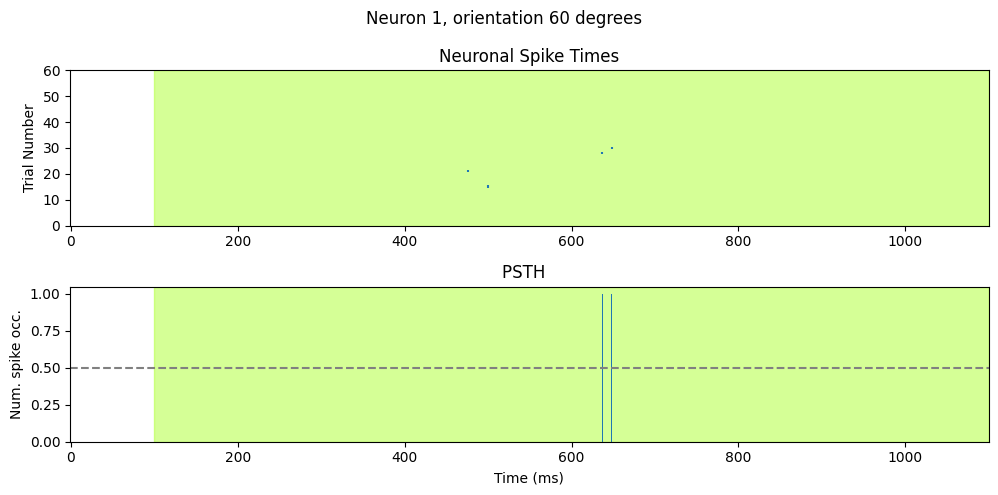

In [70]:
fig, axs = plt.subplots(2, 1, figsize=[10,5])

########################################
# draw raster into first subplot, axs[0]
# add shading for stimulus duration)
axs[0].axvspan(light_onset_time, light_offset_time, alpha=0.5, color='greenyellow')

for trial in range(60):
    spike_times = [i for i, x in enumerate(deg[trial]) if x == spike_value]
    axs[0].vlines(spike_times, trial - 0.5, trial + 0.5)

# Set x axis range so that time zero is more visible    
axs[0].set_xlim([-1, 1100])

# specify tick marks and label label y axis
axs[0].set_yticks(np.arange(0, 61, 10))
axs[0].set_ylabel('Trial Number')

axs[0].set_title('Neuronal Spike Times') 

#######################################
# draw PSTH into second subplot, axs[1]
# add shading for stimulus duration
axs[1].axvspan(light_onset_time, light_offset_time, alpha=0.5, color='greenyellow')

# Draw the PSTH
axs[1].bar(range(spike_array.shape[1]), 
           np.sum(spike_array, 0) #use mean for normalised version
           )

# Use same x axis limits as for raster plot
axs[1].set_xlim([-1, 1100])

# Add line showing chance probability of firing
axs[1].axhline(y=0.5, xmin=0, xmax=20, linestyle='--', color='gray')

# Make pretty
axs[1].set_title('PSTH  ')
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Num. spike occ.')


### Overall figure stuff
fig.suptitle(f'Neuron {neuron_nr}, orientation {degree[5:]} degrees')
plt.tight_layout()
plt.savefig(f"Raster-PSTH Neuron {neuron_nr}, {degree}.jpg")
plt.show()